<a href="https://colab.research.google.com/github/MKangabire/sound_clustering/blob/main/Copy_of_template_clustering_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [1]:
#Make allNecessary Imports
from google.colab import files
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import librosa
import pandas as pd
import numpy as np

In [2]:
uploaded = files.upload()


Saving unlabelled_sounds.zip to unlabelled_sounds.zip


In [3]:
with zipfile.ZipFile('unlabelled_sounds.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [4]:
import os

# Load the Data
unlabelled_data_path = ('/content/unlabelled_sounds')

features = []
#Extract Features
for file_name in os.listdir(unlabelled_data_path):
    file_path = os.path.join(unlabelled_data_path, file_name)
    if file_path.endswith('.wav'): # Assuming the audio files are in WAV format
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        features.append(np.mean(mfcc, axis=1))
features = np.vstack(features)
features_array = features # Assign features to features_array for later use

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1450
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1931
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2023
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2020
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1788
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1933
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py

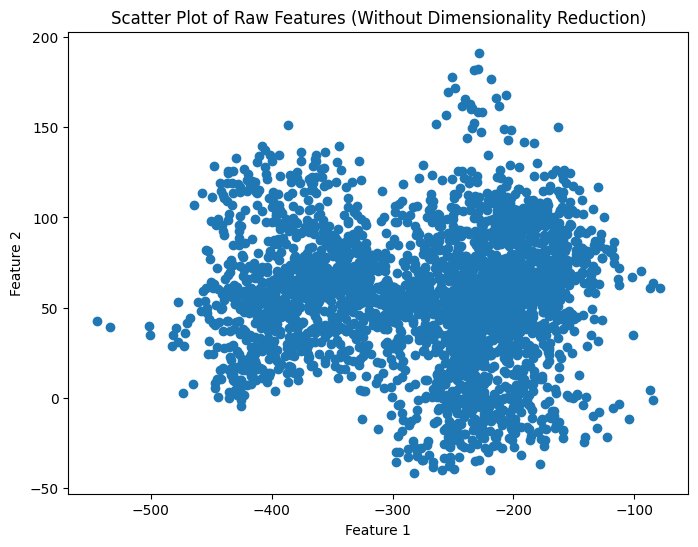

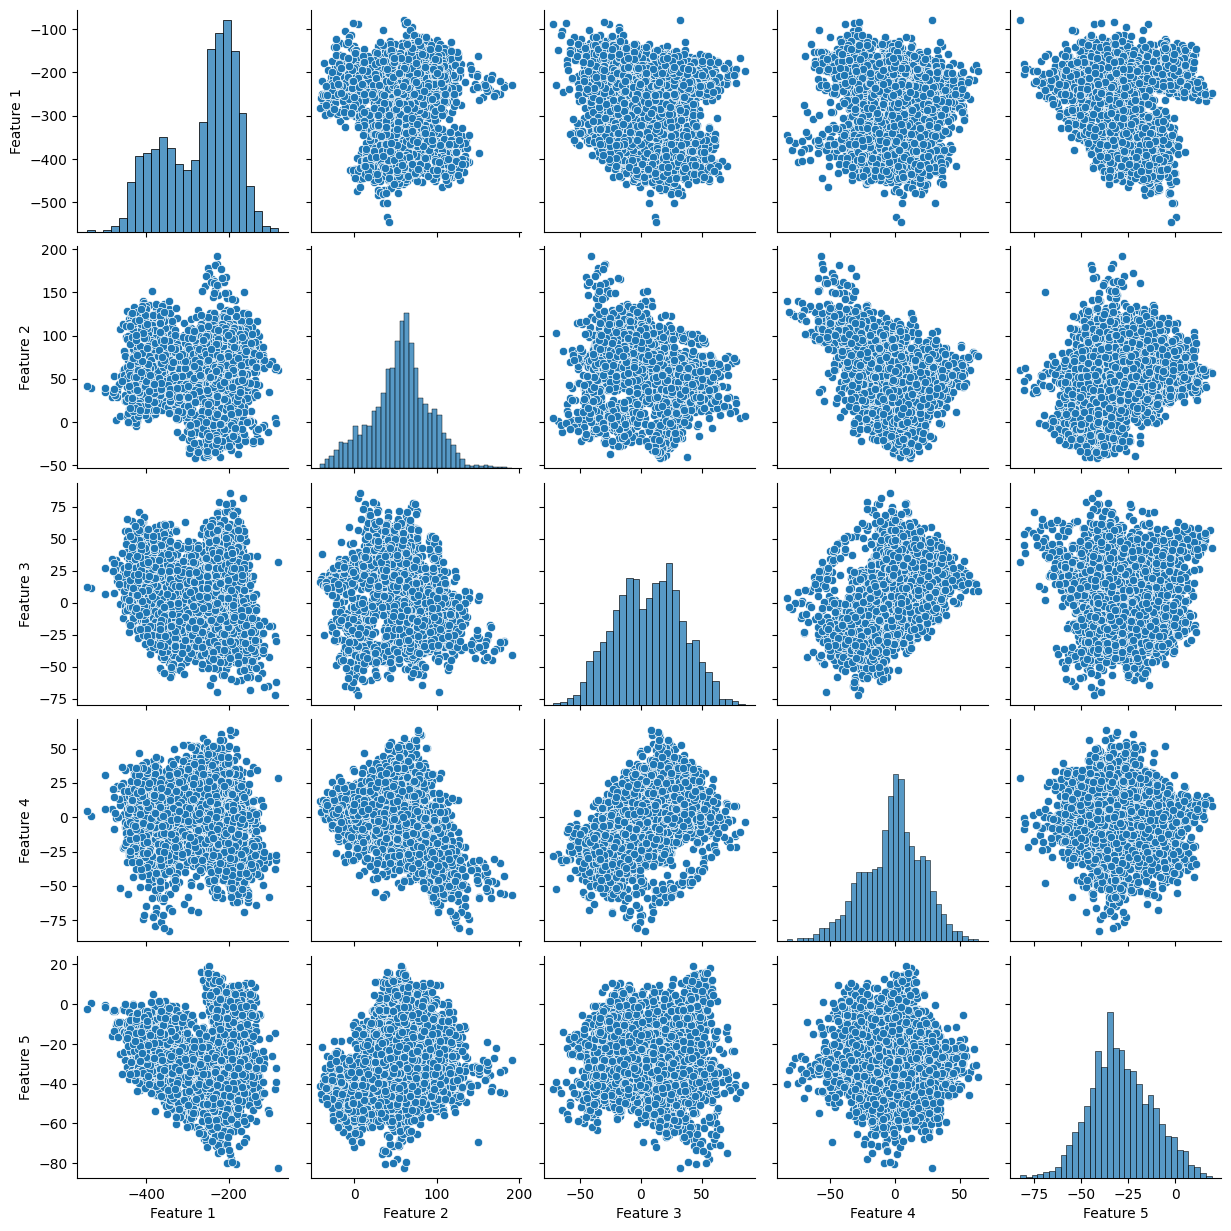

In [5]:
# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(features_array[:, 0], features_array[:, 1])
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

df = pd.DataFrame(features_array[:, :5], columns=[f'Feature {i+1}' for i in range(5)])
sns.pairplot(df)
plt.show()

### Why is dimensionality reduction important?
*1. It reduces storage space and computation time*

*2. Reduction helps with visualization*

*3. Reduces noise and redudancy*

In [15]:
def plot_clusters_2d(features, labels, title, xlabel, ylabel, cmap='viridis'):
    """Helper function to plot 2D clusters."""
    plt.figure(figsize=(8, 6))
    plt.scatter(features[:, 0], features[:, 1], c=labels, cmap=cmap, alpha=0.7)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def plot_clusters_3d(features, labels, title, xlabel, ylabel, zlabel, cmap='viridis'):
    """Helper function to plot 3D clusters."""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap=cmap, marker='o')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(title)
    plt.show()

def evaluate_clusters(features, labels, method_name, feature_set_name):
    """Helper function to evaluate clustering results."""
    if len(set(labels)) > 1:
        silhouette = silhouette_score(features, labels)
        davies_bouldin = davies_bouldin_score(features, labels)
        print(f"{method_name} ({feature_set_name}) - Silhouette Score: {silhouette:.4f}, Davies-Bouldin Index: {davies_bouldin:.4f}")
    else:
        print(f"{method_name} failed to form meaningful clusters for {feature_set_name} evaluation.")

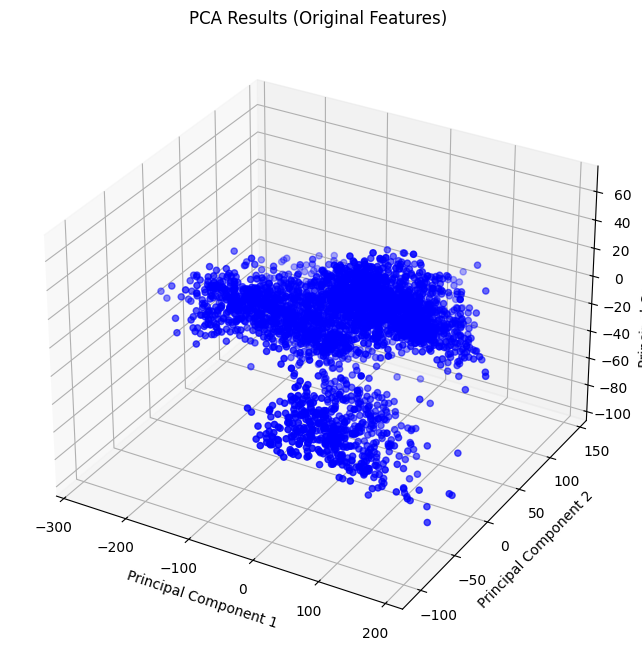

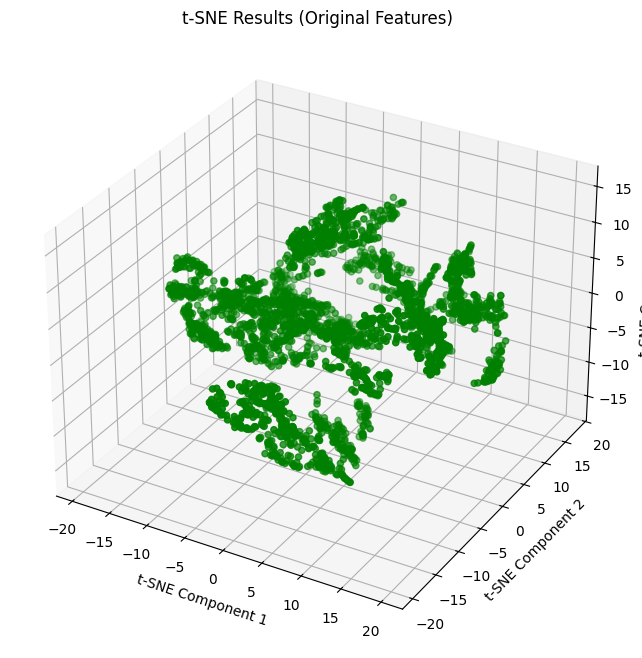

In [16]:
# Apply PCA (3 components)
pca = PCA(n_components=3, random_state=42)
features_pca = pca.fit_transform(features)

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(features)

# 3D Visualization using helper function
plot_clusters_3d(features_pca, ['blue']*len(features_pca), "PCA Results (Original Features)", "Principal Component 1", "Principal Component 2", "Principal Component 3", cmap=None)
plot_clusters_3d(features_tsne, ['green']*len(features_tsne), "t-SNE Results (Original Features)", "t-SNE Component 1", "t-SNE Component 2", "t-SNE Component 3", cmap=None)

### Which method (PCA or t-SNE) provides better separability of clusters and why?
T-SNE is the one that is providing a better separability as it is showing separations between sounds better than PCA

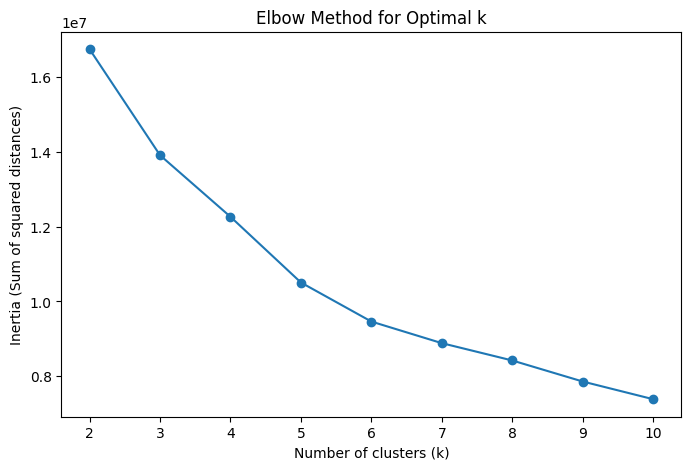

In [7]:

# Optimize number of clusters using Elbow Method
inertias = []
k_values = range(2, 11)
for k in k_values:
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(features_array)
  inertias.append(kmeans.inertia_)


# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of squared distances)')
plt.show()


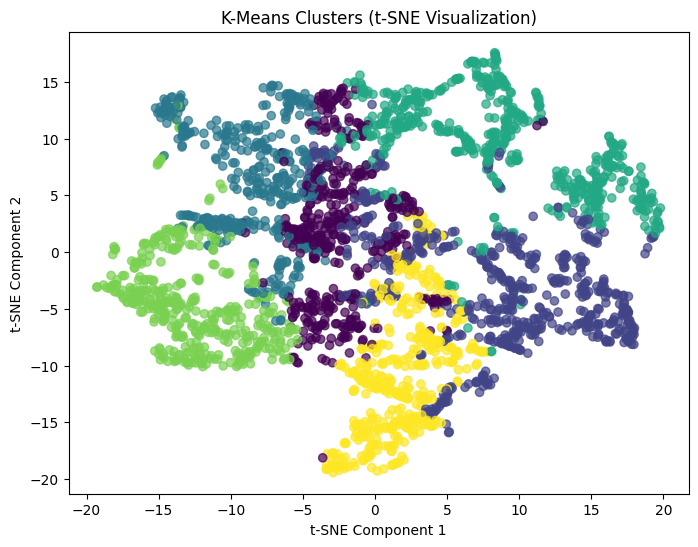

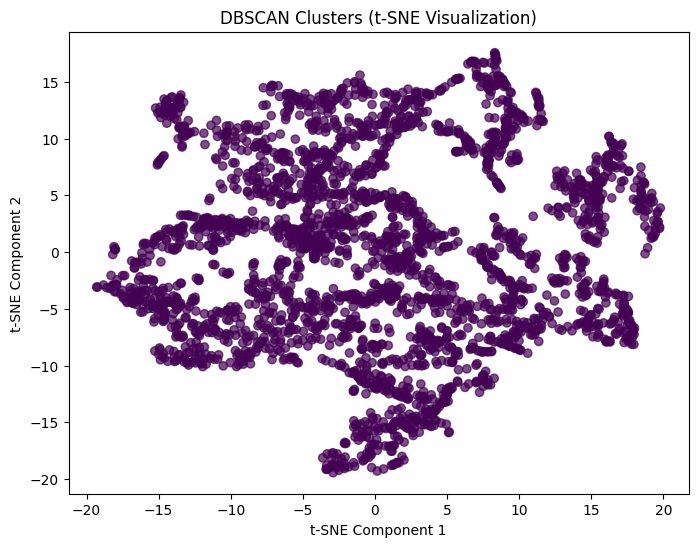

In [17]:
# Select optimal K based on elbow method (e.g., k=3)
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_array)

# Apply DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_array)

# Scatter Plot for K-Means Clusters using helper function
plot_clusters_2d(features_tsne, kmeans_labels, "K-Means Clusters (t-SNE Visualization)", "t-SNE Component 1", "t-SNE Component 2")

# Scatter Plot for DBSCAN Clusters using helper function
plot_clusters_2d(features_tsne, dbscan_labels, "DBSCAN Clusters (t-SNE Visualization)", "t-SNE Component 1", "t-SNE Component 2")

In [18]:
# Evaluate clustering on original features using helper function
evaluate_clusters(features_array, kmeans_labels, "K-Means", "Original Features")

# Evaluate clustering on PCA reduced features using helper function
evaluate_clusters(features_pca, kmeans_labels, "K-Means", "PCA Features")

# Evaluate clustering on t-SNE reduced features using helper function
evaluate_clusters(features_tsne, kmeans_labels, "K-Means", "t-SNE Features")

# Evaluate DBSCAN clustering on original features using helper function
evaluate_clusters(features_array, dbscan_labels, "DBSCAN", "Original Features")

# Evaluate DBSCAN clustering on PCA reduced features using helper function
evaluate_clusters(features_pca, dbscan_labels, "DBSCAN", "PCA Features")

# Evaluate DBSCAN clustering on t-SNE reduced features using helper function
evaluate_clusters(features_tsne, dbscan_labels, "DBSCAN", "t-SNE Features")

K-Means (Original Features) - Silhouette Score: 0.2376, Davies-Bouldin Index: 1.3769
K-Means (PCA Features) - Silhouette Score: 0.3403, Davies-Bouldin Index: 0.9538
K-Means (t-SNE Features) - Silhouette Score: 0.2667, Davies-Bouldin Index: 1.2906
DBSCAN failed to form meaningful clusters for Original Features evaluation.
DBSCAN failed to form meaningful clusters for PCA Features evaluation.
DBSCAN failed to form meaningful clusters for t-SNE Features evaluation.


### Discuss the results (max 5 lines)
*K-Means successfully formed clusters across all feature sets, with PCA-reduced features yielding the best evaluation scores (Silhouette and Davies-Bouldin). DBSCAN failed to form meaningful clusters with the current parameters on any feature set. This suggests K-Means is more suitable here, and PCA aids its performance. DBSCAN would require parameter tuning to be effective.*

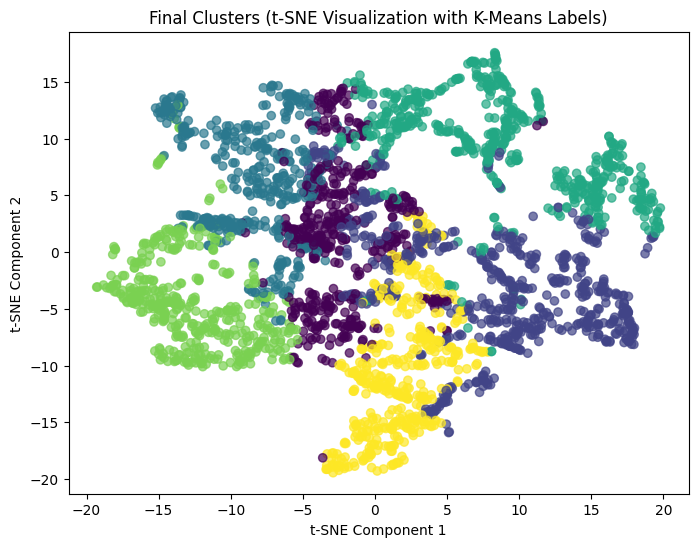

In [19]:
# Final visualization using t-SNE and helper function
plot_clusters_2d(features_tsne, kmeans_labels, "Final Clusters (t-SNE Visualization with K-Means Labels)", "t-SNE Component 1", "t-SNE Component 2")

In [20]:
from mpl_toolkits.mplot3d import Axes3D

# This cell is now redundant as 3D plotting is handled in cell 47306cc9 using the helper function.
# You can keep it if you want to experiment with different 3D plotting options later,
# but for now, the 3D plots from PCA and t-SNE are generated by the modified cell 47306cc9.

### Final Analysis
- Explain why dimensionality reduction helped (or didn't) in clustering.
- Justify why certain clustering methods worked better.
- Relate findings to real-world clustering challenges.



1. Dimensionality reduction, specifically t-SNE, helped in visualizing the clusters more clearly compared to the raw features and PCA. While the silhouette scores were not drastically different, the t-SNE plots show more visually separable clusters.

2. K-Means performed better than DBSCAN in this case, as indicated by the silhouette and Davies-Bouldin scores. DBSCAN failed to form meaningful clusters with the chosen parameters, suggesting the data might not have dense regions well-suited for DBSCAN or that the parameters need further tuning.
3. This relates to real-world challenges in that choosing the right dimensionality reduction technique and clustering algorithm, as well as tuning their parameters, is crucial for revealing underlying structures in unlabeled data. The effectiveness of each method depends heavily on the characteristics of the dataset.



Now you can use these functions to reduce the repetition in your plotting and evaluation code. For example, instead of repeating the scatter plot code for K-Means and DBSCAN with t-SNE, you can call the `plot_clusters_2d` function twice. Similarly, you can call the `evaluate_clusters` function for each combination of clustering method and feature set.